# 04. Cell Fate Quantification

This notebook will introduce the usage of cell fate quantification with vector field.

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
import os
import cospar as cs
import pygot
from tqdm import tqdm
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

In here, we use the subset of in vitro hematopoiesis data from [Weinreb et al. (2020)](https://www.science.org/doi/10.1126/science.aaw3381) Based on lineage-tracing technology, Weinreb et al. track clones of cells (cell families) across time (day2, day4, day6). 

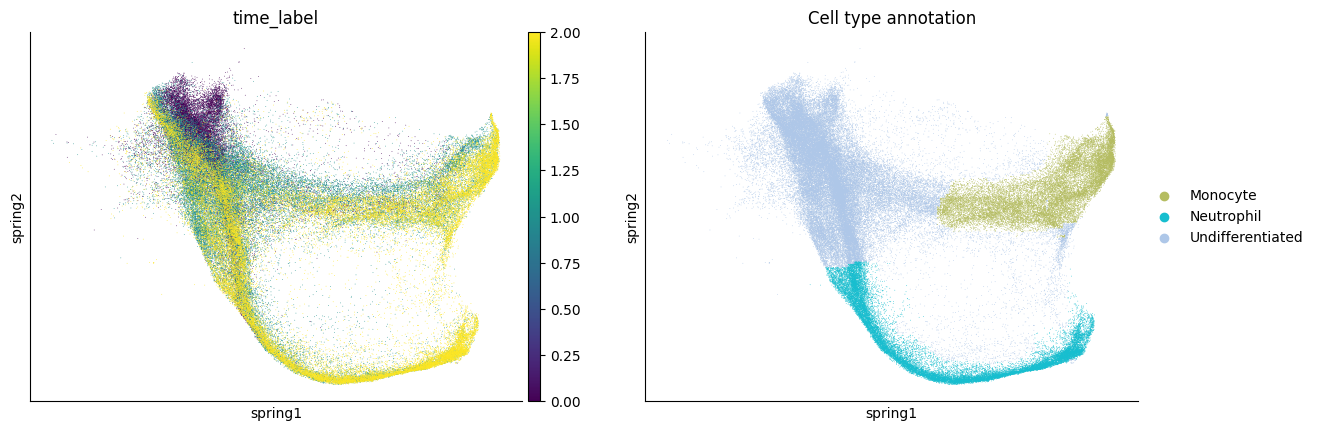

In [2]:
adata = sc.read_h5ad('../../pygot_data/03_cellfate/adata_hpsc.h5ad')

time_key = 'Time point'
ts = np.sort(np.unique(adata.obs[time_key]))
ts_map = dict(zip(ts, range(len(ts))))
adata.obs['time_label'] = adata.obs[time_key].replace(ts_map)

embedding_key = 'X_pca'
velocity_key = 'velocity_pca'
time_key = 'time_label' 
cell_type_key = 'Cell type annotation'
sc.pl.embedding(adata,basis='spring',color=[time_key, cell_type_key])


Since the first two components seperate monocyte and neutrophil lineage well, we keep the first 10 components as the latent space.

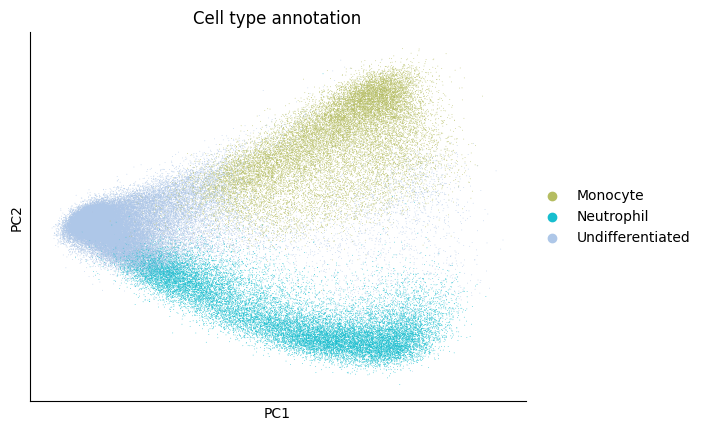

In [3]:
sc.pl.pca(adata, color=cell_type_key)
adata.obsm['X_pca'] = adata.obsm['X_pca'][:,:10]
adata.varm['PCs'] = adata.varm['PCs'][:,:10]

## Compute Grond Truth based on Clone Information

To obtain the groundtruth of fate bias, we use cospar to leverage clone information to compute the clonal fraction of differention cell type as the fate bias.

In [4]:
from scipy.sparse import csr_matrix
clone_key = 'clone'
clone_library = adata.obs[clone_key][~np.isnan(adata.obs[clone_key])].unique()
X_clone = np.zeros(shape=(len(adata), len(clone_library)))
for i in range(len(clone_library)):
    X_clone[np.where(adata.obs[clone_key] == clone_library[i])[0], i] = 1
X_clone = csr_matrix(X_clone)
adata.obsm['X_clone'] = X_clone

In [5]:
adata.obs['time_info'] = adata.obs[time_key]
adata.obs['state_info'] = adata.obs[cell_type_key]
adata.obsm['X_emb'] = adata.obsm['X_spring']

Infer transition map between neighboring time points.
--> Clonal cell fraction (day 0.0-1.0): 0.07878156471697177
--> Clonal cell fraction (day 1.0-2.0): 0.22397881600335587
--> Clonal cell fraction (day 1.0-0.0): 0.11234334853966756
--> Clonal cell fraction (day 2.0-1.0): 0.45161798697205296
--> Numer of cells that are clonally related -- day 0.0: 1588  and day 1.0: 4285
--> Numer of cells that are clonally related -- day 1.0: 8543  and day 2.0: 17194
Number of multi-time clones post selection: 2625
Cell number=96371, Clone number=2625
--> clonal_cell_id_t1: 10131
--> Tmap_cell_id_t1: 58299
Use all clones (naive method)
Use all clones (naive method)


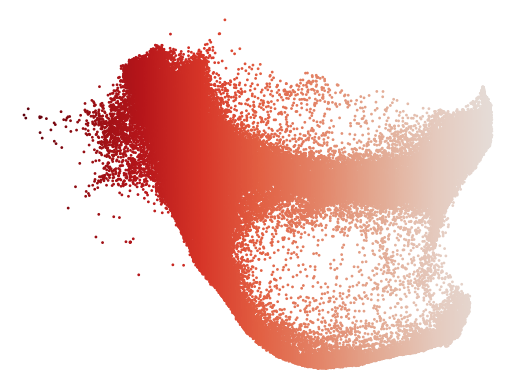

In [6]:

adata_processed = cs.tmap.infer_Tmap_from_clonal_info_alone(
    adata,
)

In [7]:
cs.tl.fate_map(
    adata_processed,
    selected_fates=["Neutrophil", "Monocyte"],
    source="clonal_transition_map",
    map_backward=True,
)

adata_processed.obs['Cospar_fate_bias'] = adata_processed.obs['fate_map_clonal_transition_map_Neutrophil'] / (adata_processed.obs['fate_map_clonal_transition_map_Neutrophil'] + adata_processed.obs['fate_map_clonal_transition_map_Monocyte'])

Results saved at adata.obs['fate_map_clonal_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_clonal_transition_map_Monocyte']


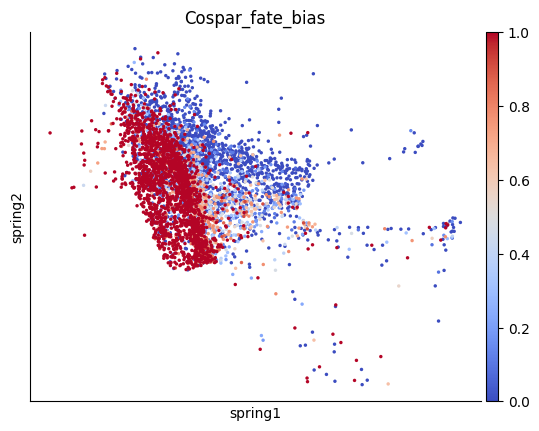

In [8]:
x0_adata = adata_processed[  (adata_processed.obs[cell_type_key] == 'Undifferentiated') & (~np.isnan(adata_processed.obs['Cospar_fate_bias']))].copy()
groundtruth_key = 'Cospar_fate_bias'
sc.pl.embedding(x0_adata, color='Cospar_fate_bias', basis='spring',cmap='coolwarm')

## Fitting velocity model

Next, we use the time label information to fit the velocity model

In [9]:
model, history = pygot.tl.traj.fit_velocity_model(adata, embedding_key=embedding_key, time_key=time_key, path='../../pygot_data/03_cellfate/hpsc/k50_all/')

loading saved shortest path profile


loss :18.5750  best :18.4316: 100%|███████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.93it/s]


In [10]:
velocity_key = 'velocity_pca'
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, time_key=time_key, embedding_key=embedding_key)
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space


Plot the velocity field

computing velocity embedding
    finished (0:00:26) --> added
    'velocity_spring', embedded velocity vectors (adata.obsm)


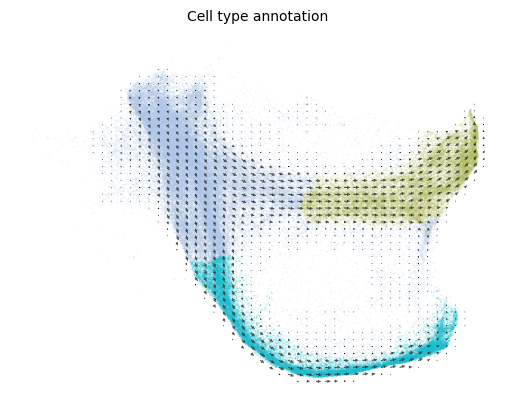

In [11]:
scv.pl.velocity_embedding_grid(adata, basis='spring', color=cell_type_key)

## Use abosrbing probability of Markov chain to predict cell type probability

In [12]:
cf = pygot.tl.analysis.CellFate()
cf.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key=cell_type_key, target_cell_types=[
    'Monocyte',
    'Neutrophil',
]
       )

2025-05-04 15:12:02 	 Compute transition roadmap among [0 1]
2025-05-04 15:12:02 	 Compute transition between 0 and 1
2025-05-04 15:12:05 	 Compute velocity graph
Isolated node: 0.4016%
2025-05-04 15:13:04 	 Convert into markov chain
2025-05-04 15:13:04 	 Solve abosorbing probabilities
2025-05-04 15:13:06 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']


The undifferentiated cells in the early stage are quantified

In [13]:
# Descendant probabilities
adata.obsm['descendant']

,Monocyte,Neutrophil
0,0.019251,0.980749
1,1.000000,0.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
96368,0.000000,1.000000
96369,0.291203,0.708797
96370,1.000000,0.000000
96371,1.000000,0.000000


In [14]:
# Ancestor probabilities
adata.obsm['ancestor']

,Undifferentiated
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
96368,1.0
96369,1.0
96370,1.0
96371,1.0


The cell fate probabilities result is very similar to the groundtruth, which is quantified by lineage-barcode.

In [16]:
adata.obs['pred_fate_bias'] = adata.obs['Neutrophil']
adata.obs.loc[np.isnan(adata.obs['pred_fate_bias']),'pred_fate_bias'] = 0.5
adata.obs['pred_fate_bias']

0        0.980749
1        0.000000
2        1.000000
3        1.000000
4        1.000000
           ...   
96368    1.000000
96369    0.708797
96370    0.000000
96371    0.000000
96372    0.854383
Name: pred_fate_bias, Length: 96371, dtype: float64

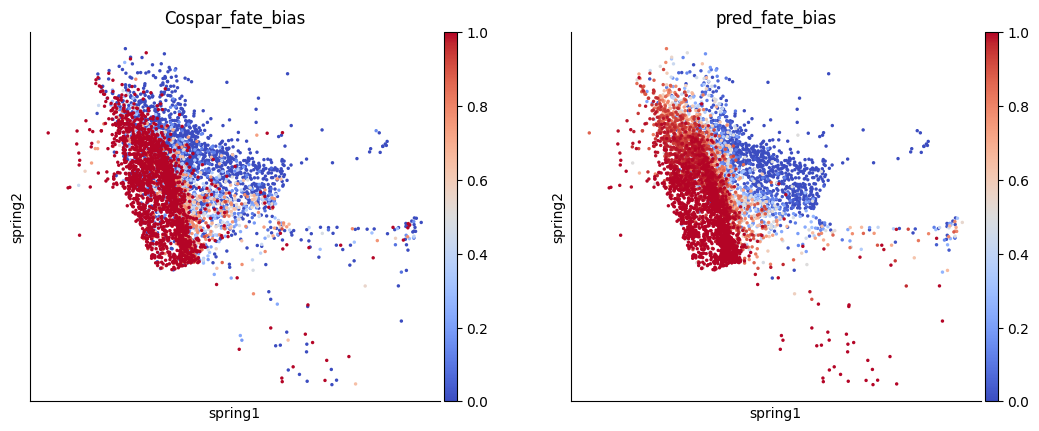

PearsonRResult(statistic=0.6164419908753795, pvalue=0.0)

In [21]:
from scipy.stats import pearsonr
fig, axes = plt.subplots(1,2, figsize=( 6.4*2, 4.8))
sc.pl.embedding(x0_adata, color=groundtruth_key, ax=axes[0], show=False, basis='spring', cmap='coolwarm')
sc.pl.embedding(adata[x0_adata.obs.index], color='pred_fate_bias', ax=axes[1], basis='spring', cmap='coolwarm')
pearsonr(x0_adata.obs[groundtruth_key], adata.obs.loc[x0_adata.obs.index, 'pred_fate_bias'])